In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, fbeta_score, make_scorer

sns.set_theme(style='whitegrid', context='paper')

In [10]:
# Read in column names from 'data/network-traffic/kddcup.names.dat'
import re

with open('data/network-traffic/kddcup.names.dat') as file:
    col_re = r'(\w+)\:.*'
    cols = [re.search(col_re, line)[1] for line in file.readlines()[1:]] + ['target']

cols[:5]

['duration', 'protocol_type', 'service', 'flag', 'src_bytes']

In [37]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.csv', names=cols, index_col=False, header=None).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', names=cols, index_col=False, header=None).drop_duplicates()
complete_df = pd.concat([training_df, testing_df], axis=0)

training_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal


--------------------------------------------------------------------------------

# Preprocessing

In [12]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1154080 entries, 0 to 310931
Data columns (total 42 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   duration                     1154080 non-null  int64  
 1   protocol_type                1154080 non-null  object 
 2   service                      1154080 non-null  object 
 3   flag                         1154080 non-null  object 
 4   src_bytes                    1154080 non-null  int64  
 5   dst_bytes                    1154080 non-null  int64  
 6   land                         1154080 non-null  int64  
 7   wrong_fragment               1154080 non-null  int64  
 8   urgent                       1154080 non-null  int64  
 9   hot                          1154080 non-null  int64  
 10  num_failed_logins            1154080 non-null  int64  
 11  logged_in                    1154080 non-null  int64  
 12  num_compromised              1154080 non-null  i

In [27]:
# Handle columns with `object`-type values
object_column_names = [complete_df[col].name for col in complete_df.columns if complete_df[col].dtype == 'object']
print(f'There are {len(object_column_names)} columns of type `object`: {object_column_names}.')

There are 4 columns of type `object`: ['protocol_type', 'service', 'flag', 'target'].


In [33]:
# Check out the 'protocol_type'
training_df.protocol_type.unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [34]:
# Check out the `service`
training_df.service.unique()

array(['http', 'smtp', 'domain_u', 'auth', 'finger', 'telnet', 'eco_i',
       'ftp', 'ntp_u', 'ecr_i', 'other', 'urp_i', 'private', 'pop_3',
       'ftp_data', 'netstat', 'daytime', 'ssh', 'echo', 'time', 'name',
       'whois', 'domain', 'mtp', 'gopher', 'remote_job', 'rje', 'ctf',
       'supdup', 'link', 'systat', 'discard', 'X11', 'shell', 'login',
       'imap4', 'nntp', 'uucp', 'pm_dump', 'IRC', 'Z39_50', 'netbios_dgm',
       'ldap', 'sunrpc', 'courier', 'exec', 'bgp', 'csnet_ns', 'http_443',
       'klogin', 'printer', 'netbios_ssn', 'pop_2', 'nnsp', 'efs',
       'hostnames', 'uucp_path', 'sql_net', 'vmnet', 'iso_tsap',
       'netbios_ns', 'kshell', 'urh_i', 'http_2784', 'harvest', 'aol',
       'tftp_u', 'http_8001', 'tim_i', 'red_i'], dtype=object)

In [35]:
# Check out the `flag`
training_df.flag.unique()

array(['SF', 'S2', 'S1', 'S3', 'OTH', 'REJ', 'RSTO', 'S0', 'RSTR',
       'RSTOS0', 'SH'], dtype=object)

In [38]:
# check out the `target`
training_df.target.unique()     # -> one-hot

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'],
      dtype=object)

We will use a simple enumeration approach for those, each column with its own encoding and decoding function.

In [107]:
def encode(value, catalog): return catalog.index(value)
def decode(value, catalog): return catalog[value]
def make_encoding(column_name, dataframe):
    catalog = dataframe[column_name].unique().tolist()
    def encoder(value): return encode(value, catalog)
    def decoder(value): return decode(value, catalog)
    return catalog, encoder, decoder
def make_encoded_column(column_name, dataframe, encodings=None):
    catalog, encoder, decoder = encodings or make_encoding(column_name, dataframe)
    result = dataframe[column_name].map(encoder)
    result.name = f'{column_name}_enc'
    return result, catalog, encoder, decoder
def make_encoded_df(original_df, column_names, encodings=None):
    new_df = original_df.copy()
    def encode_columns(df, columns, encodings, make_new_encodings=True):
        match columns, make_new_encodings:
            case [], _:
                return df, encodings
            case [column, *rest], True:
                new_col, catalog, encoder, decoder = make_encoded_column(column, df)
                new_df = pd.concat([df.drop(column, axis=1), new_col], axis=1)
                return encode_columns(new_df, rest, encodings + [[catalog, encoder, decoder]])
            case [column, *rest], False:
                new_col, _, _, _ = make_encoded_column(column, df, encodings[-len(columns)])
                new_df = pd.concat([df.drop(column, axis=1), new_col], axis=1)
                return encode_columns(new_df, rest, encodings, make_new_encodings)
    return encode_columns(new_df, column_names, [])

In [108]:
# Use those functions to create fully-encoded dataframes (copies):
testing_df_enc, encodings = make_encoded_df(testing_df, object_column_names)
training_df_enc, _ = make_encoded_df(training_df, object_column_names, encodings)

In [109]:
training_df_enc.tail()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_enc,service_enc,flag_enc,target_enc
4898426,0,212,2288,0,0,0,0,0,1,0,...,0.33,0.05,0.0,0.01,0.0,0.0,0,0,0,0
4898427,0,219,236,0,0,0,0,0,1,0,...,0.25,0.05,0.0,0.01,0.0,0.0,0,0,0,0
4898428,0,218,3610,0,0,0,0,0,1,0,...,0.20,0.05,0.0,0.01,0.0,0.0,0,0,0,0
4898429,0,219,1234,0,0,0,0,0,1,0,...,0.17,0.05,0.0,0.01,0.0,0.0,0,0,0,0
4898430,0,219,1098,0,0,0,0,0,1,0,...,0.14,0.05,0.0,0.01,0.0,0.0,0,0,0,0


In [102]:
training_df_enc.dtypes

duration                         int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate                float64
rerror_rate                    float64
srv_rerror_rate                float64
same_srv_rate            

Moving forward, we will use the encoded data frames, since the models require numeric input.
At any point, the original values can be re-constructed by using the respective decoder within
the captured `encodings` list. The order of these encodings matches the order of the respective
column names in the `object_column_names` list. Alternatively, the following dictionary can be
used for convenience:

In [120]:
encodings_dict = {
    column: {
        'catalog': encoding[0],
        'encoder': encoding[1],
        'decoder': encoding[2],
    }
    for column, encoding in zip(object_column_names, encodings)
}

--------------------------------------------------------------------------------

# Metrics and Reduced Datasets for HPT

In [64]:
# Metrics
beta = 10
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [82]:
# Important Data Subset
corr_ = abs(training_df_enc.corr()['target_enc'])[:-1]
relevant_columns = corr_[corr_ >= 0.05].index.tolist()
print(f'Columns with a correlation value greater than 0.05 are:\n{relevant_columns}\n({len(relevant_columns)} in total)')

Columns with a correlation value greater than 0.05 are:
['wrong_fragment', 'hot', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_enc', 'service_enc', 'flag_enc']
(22 in total)


In [83]:
X_train = training_df_enc[relevant_columns]
y_train = training_df_enc.target_enc
X_test  = testing_df_enc[relevant_columns]
y_true  = testing_df_enc.target_enc

--------------------------------------------------------------------------------

# Random Forest Classification

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=404
).fit(X_train, y_train)

In [85]:
rf_pred = rf_model.predict(X_test)

In [122]:
print(f'{(rf_accuracy := accuracy_score(y_true, rf_pred)) = }')
print(f'{(rf_fbeta := fbeta_score(y_true, rf_pred, beta=beta, average=None)) = }\n')
print(classification_report(y_true, rf_pred))

(rf_accuracy := accuracy_score(y_true, rf_pred)) = 0.6170834896689136
(rf_fbeta := fbeta_score(y_true, rf_pred, beta=beta, average=None)) = array([0.993298  , 0.        , 0.        , 0.        , 0.        ,
       0.00614467, 0.        , 0.        , 0.        , 0.        ,
       0.11864499, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07657316, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     47913
           1       0.00      0.00      0.00       179
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00       936
           5       0.

/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [142]:
# Repeat, but look at each target value separately:
focused_rf_models_tvalues = {target: idx for idx, target in enumerate(encodings_dict['target']['catalog'])}
def make_random_forest(target_name, target_value, X_train, y_train, n_estimators, max_depth):
    focused_y_train = y_train.map(lambda value: int(value==target_value))
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=404
    ).fit(X_train, focused_y_train)
    return target_name, model
focused_rf_models = dict([make_random_forest(target, value, X_train, y_train, n_estimators=100, max_depth=None) for target, value in focused_rf_models_tvalues.items()])

In [143]:
focused_rf_predictions = {target: model.predict(X_test) for target, model in focused_rf_models.items()}
focused_rf_true = {target: y_true.map(lambda value: int(value==t_value)) for target, t_value in focused_rf_models_tvalues.items()}
focused_rf_scores = {
    target: {
        'accuracy': accuracy_score(focused_rf_true[target], prediction),
        'fbeta_score': fbeta_score(focused_rf_true[target], prediction, beta=beta)
    }
    for target, prediction in focused_rf_predictions.items()
}
# Present the results
index_col_len = max(map(len, focused_rf_models.keys()))
print(f'{index_col_len*" "}\taccuracy\tfbeta')
for target, result in focused_rf_scores.items():
    print(f'{target + (index_col_len - len(target))*" "}\t{result["accuracy"]:.6f}\t{result["fbeta_score"]:.6f}')

               	accuracy	fbeta
normal         	0.920754	0.993075
snmpgetattack  	0.997645	0.000000
named          	0.999767	0.000000
xlock          	0.999884	0.000000
smurf          	0.755030	0.000000
ipsweep        	0.985897	0.006145
multihop       	0.999767	0.000000
xsnoop         	0.999237	0.000000
sendmail       	0.999806	0.000000
guess_passwd   	0.981046	0.000000
saint          	0.993841	0.118668
buffer_overflow	0.999715	0.000000
portsweep      	0.997749	0.000000
pod            	0.997723	0.000000
apache2        	0.989727	0.000000
phf            	0.987088	0.000000
udpstorm       	0.999974	0.000000
warezmaster    	0.986273	0.000000
perl           	0.999974	0.000000
satan          	0.988873	0.000000
xterm          	0.999470	0.227136
mscan          	0.986428	0.000000
processtable   	0.990374	0.000000
ps             	0.999793	0.000000
nmap           	0.998965	0.000000
rootkit        	0.999832	0.000000
neptune        	0.736942	0.000000
loadmodule     	0.999974	0.000000
imap           	0

In [169]:
from sklearn.metrics import confusion_matrix

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap='viridis')
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

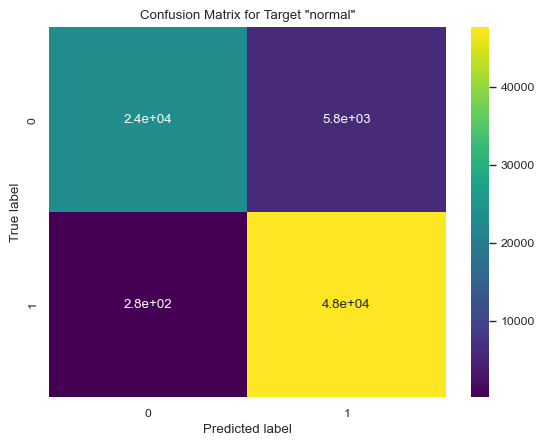

accuracy   : 0.920754
fbeta_score: 0.993075



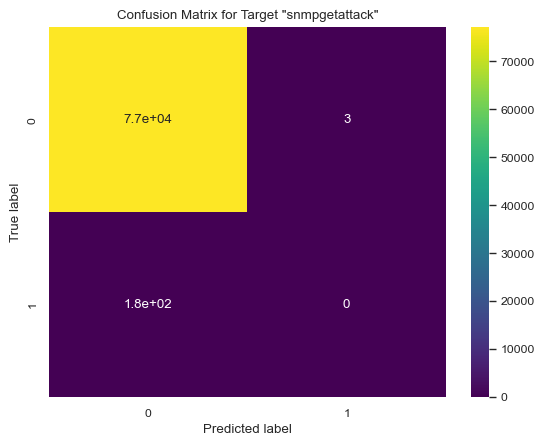

accuracy   : 0.997645
fbeta_score: 0.000000



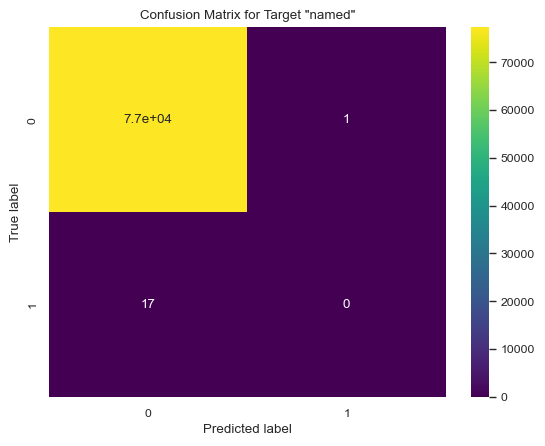

accuracy   : 0.999767
fbeta_score: 0.000000



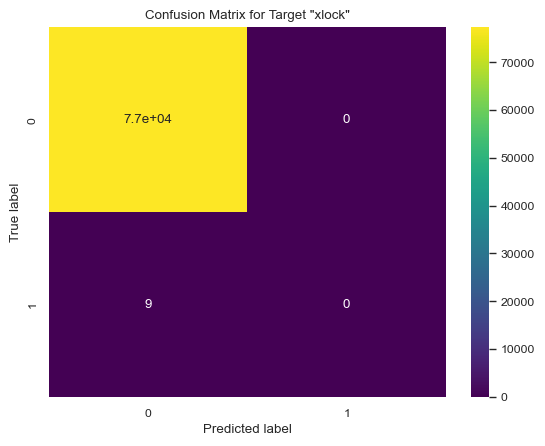

accuracy   : 0.999884
fbeta_score: 0.000000



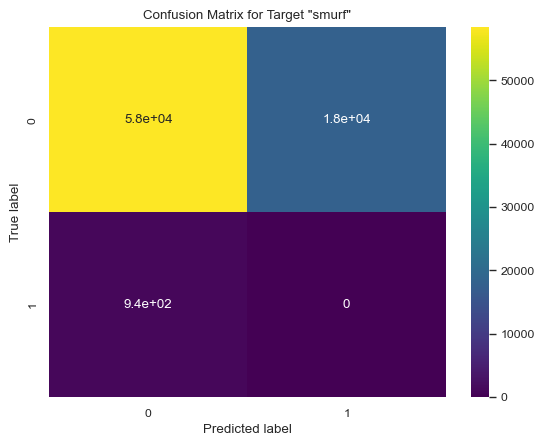

accuracy   : 0.755030
fbeta_score: 0.000000



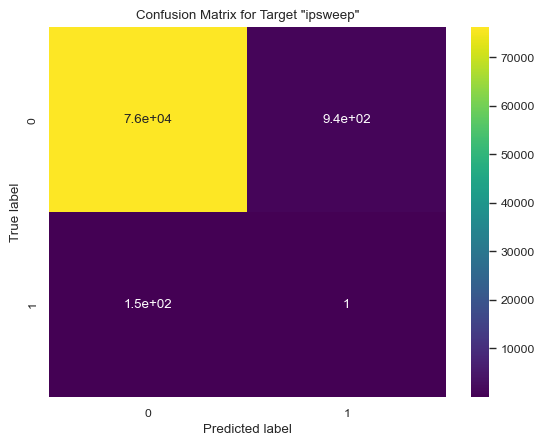

accuracy   : 0.985897
fbeta_score: 0.006145



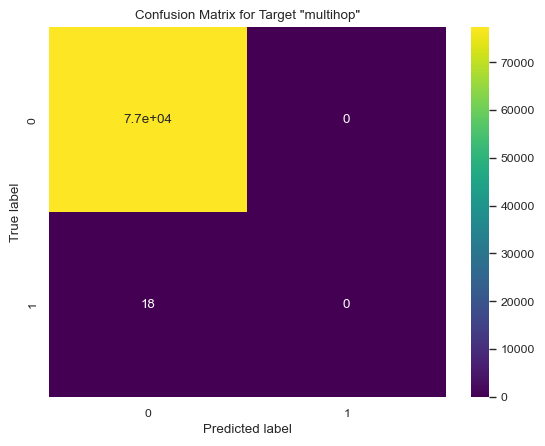

accuracy   : 0.999767
fbeta_score: 0.000000



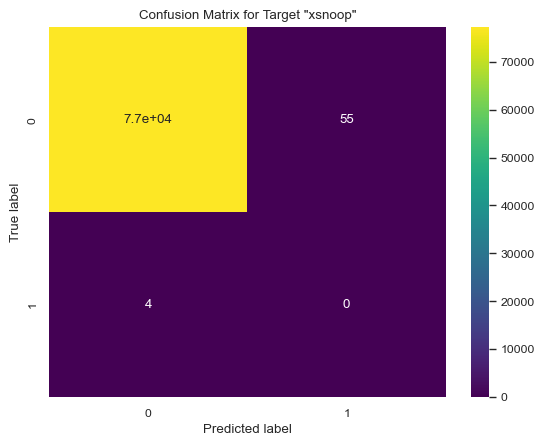

accuracy   : 0.999237
fbeta_score: 0.000000



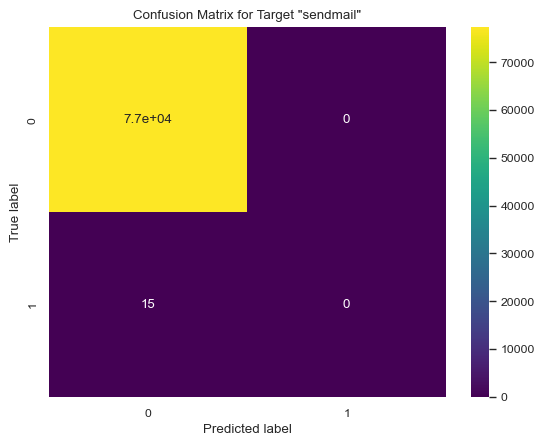

accuracy   : 0.999806
fbeta_score: 0.000000



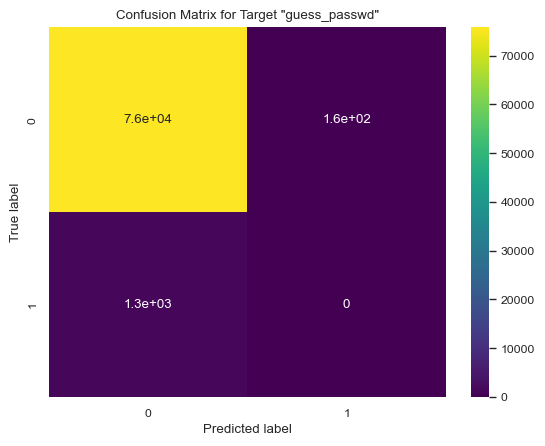

accuracy   : 0.981046
fbeta_score: 0.000000



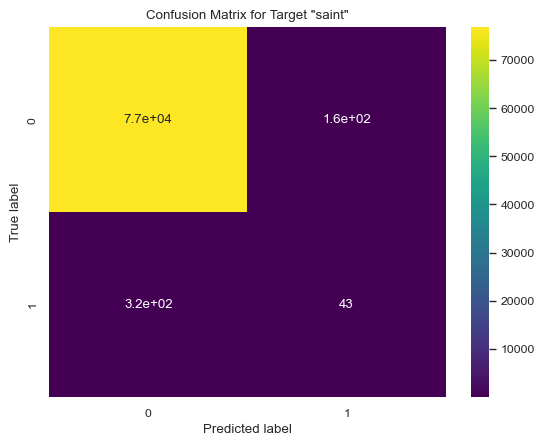

accuracy   : 0.993841
fbeta_score: 0.118668



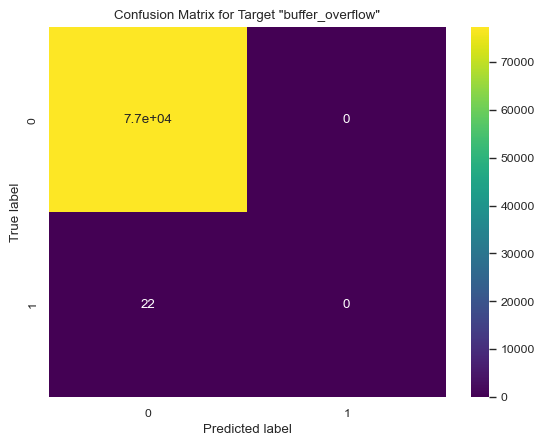

accuracy   : 0.999715
fbeta_score: 0.000000



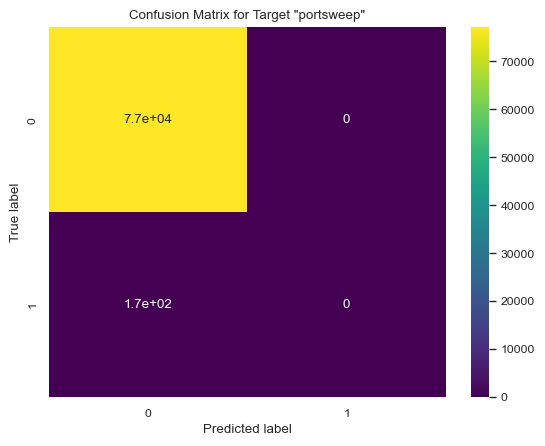

accuracy   : 0.997749
fbeta_score: 0.000000



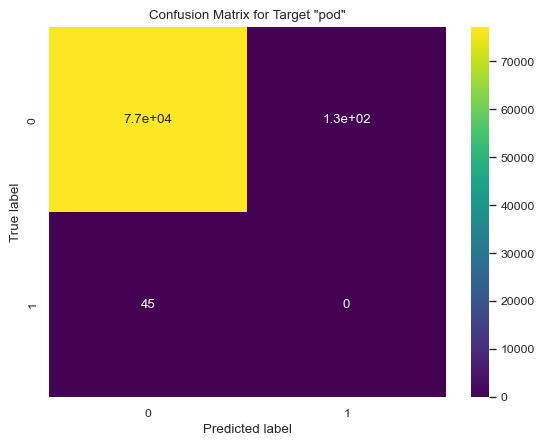

accuracy   : 0.997723
fbeta_score: 0.000000



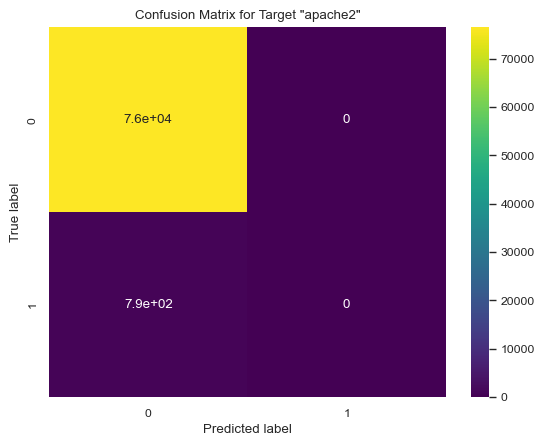

accuracy   : 0.989727
fbeta_score: 0.000000



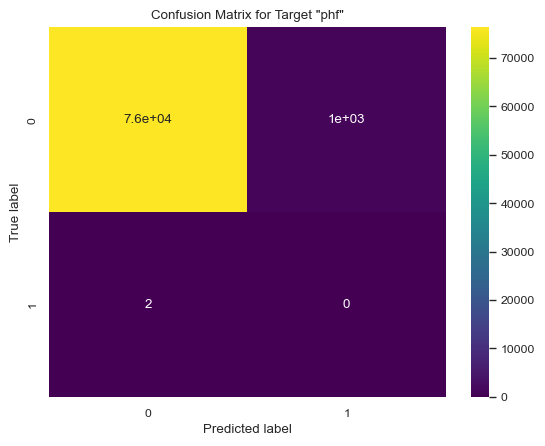

accuracy   : 0.987088
fbeta_score: 0.000000



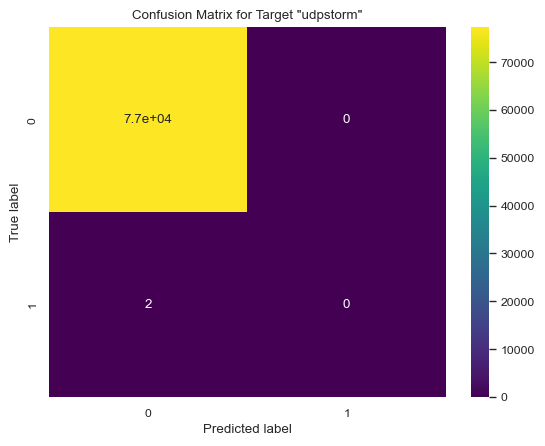

accuracy   : 0.999974
fbeta_score: 0.000000



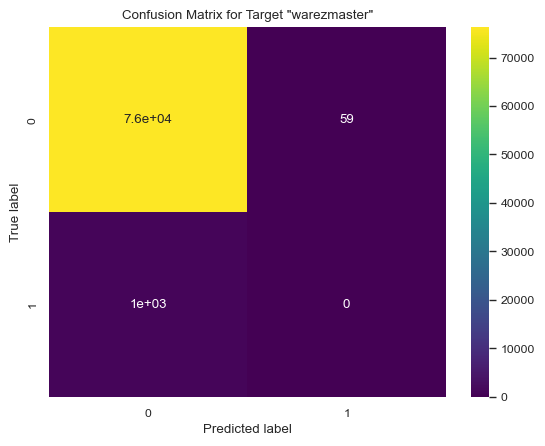

accuracy   : 0.986273
fbeta_score: 0.000000



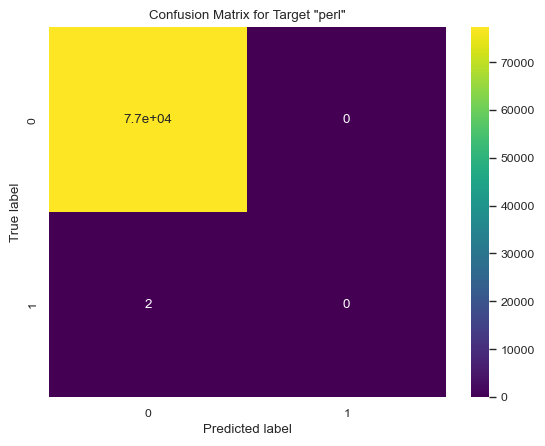

accuracy   : 0.999974
fbeta_score: 0.000000



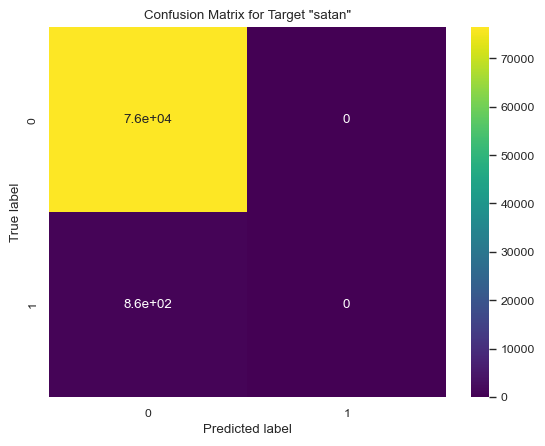

accuracy   : 0.988873
fbeta_score: 0.000000



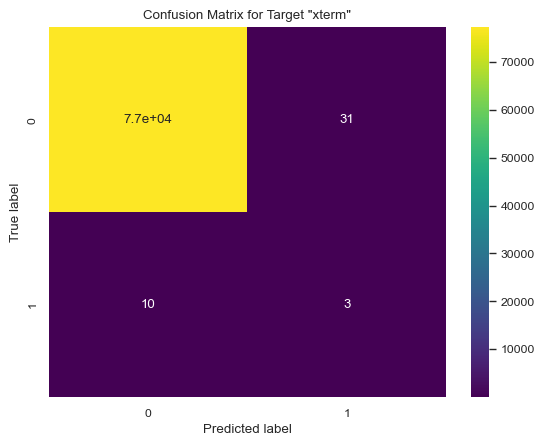

accuracy   : 0.999470
fbeta_score: 0.227136



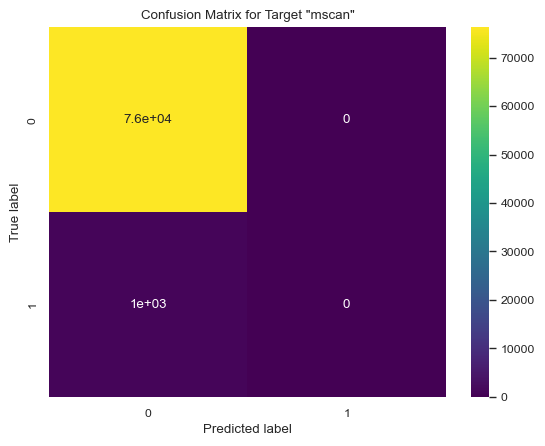

accuracy   : 0.986428
fbeta_score: 0.000000



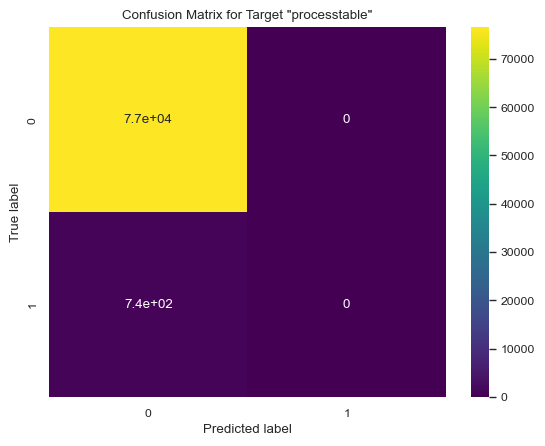

accuracy   : 0.990374
fbeta_score: 0.000000



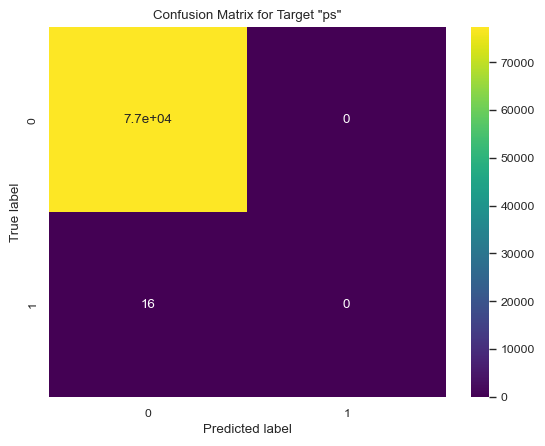

accuracy   : 0.999793
fbeta_score: 0.000000



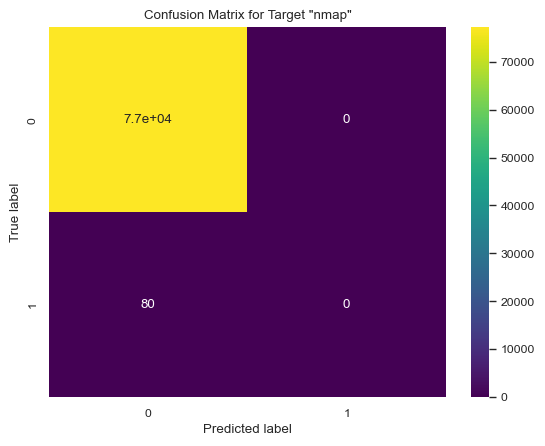

accuracy   : 0.998965
fbeta_score: 0.000000



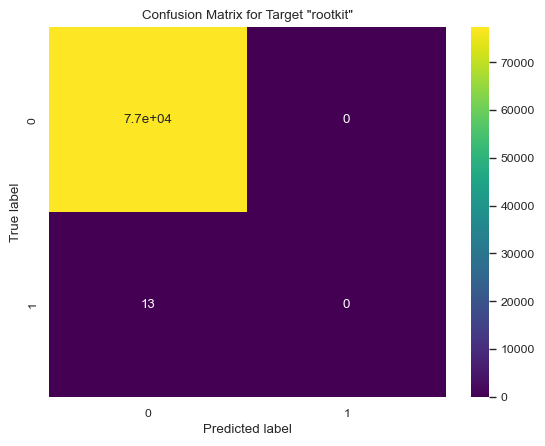

accuracy   : 0.999832
fbeta_score: 0.000000



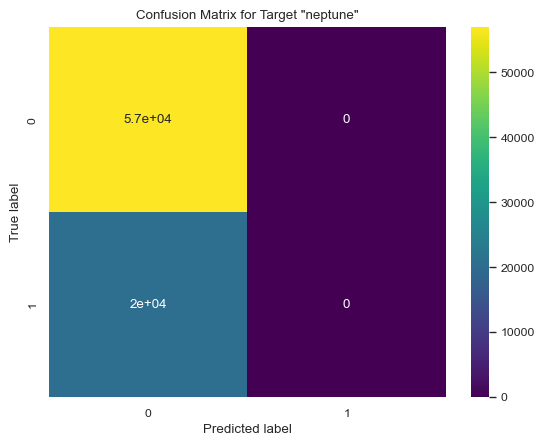

accuracy   : 0.736942
fbeta_score: 0.000000



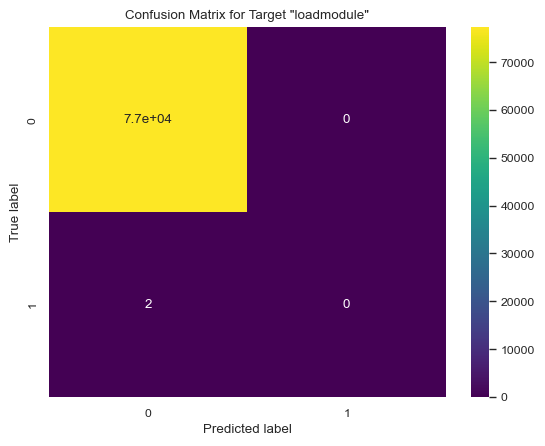

accuracy   : 0.999974
fbeta_score: 0.000000



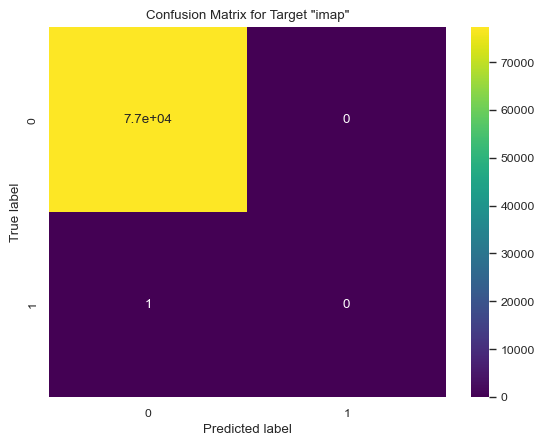

accuracy   : 0.999987
fbeta_score: 0.000000



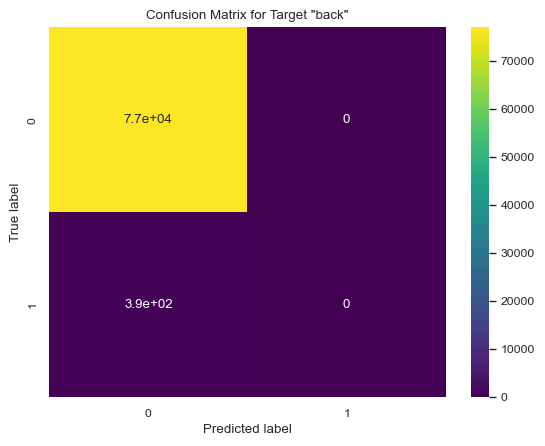

accuracy   : 0.995006
fbeta_score: 0.000000



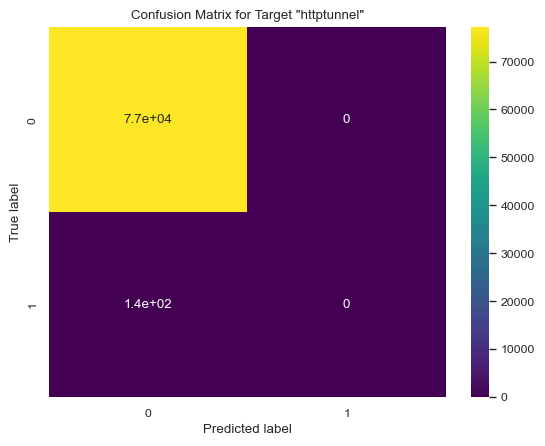

accuracy   : 0.998124
fbeta_score: 0.000000



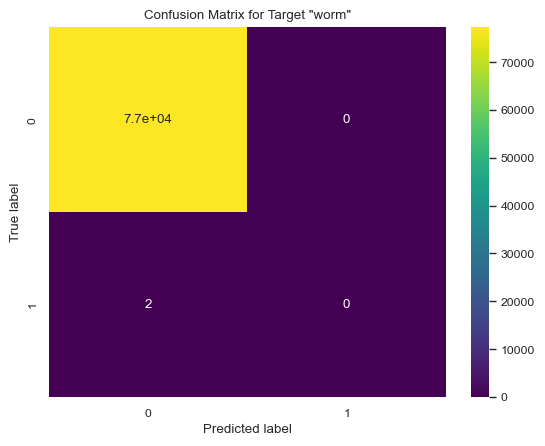

accuracy   : 0.999974
fbeta_score: 0.000000



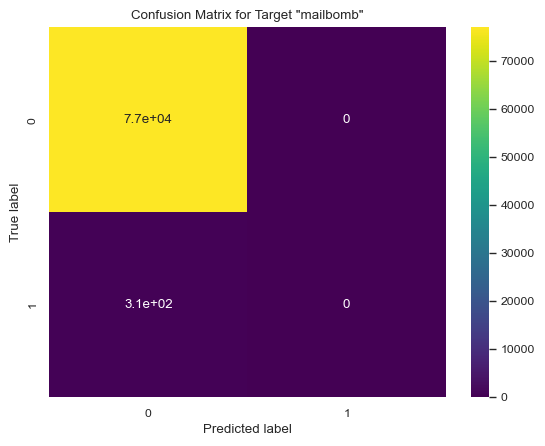

accuracy   : 0.996015
fbeta_score: 0.000000



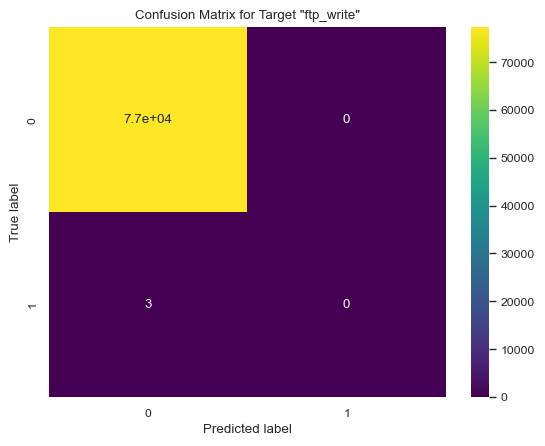

accuracy   : 0.999961
fbeta_score: 0.000000



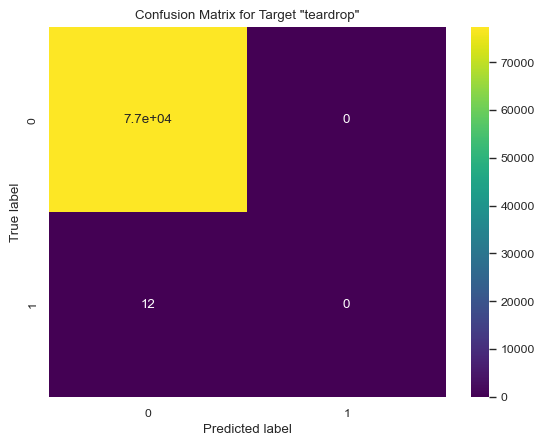

accuracy   : 0.999845
fbeta_score: 0.000000



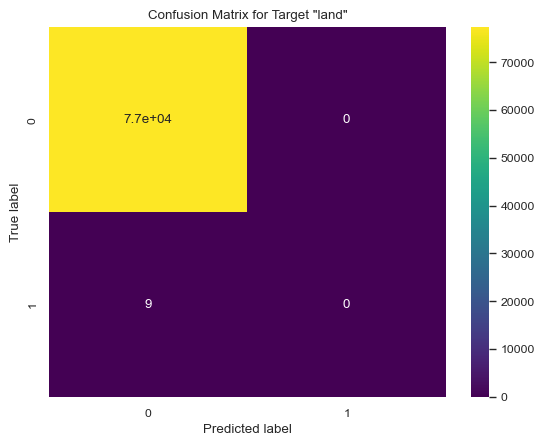

accuracy   : 0.999884
fbeta_score: 0.000000



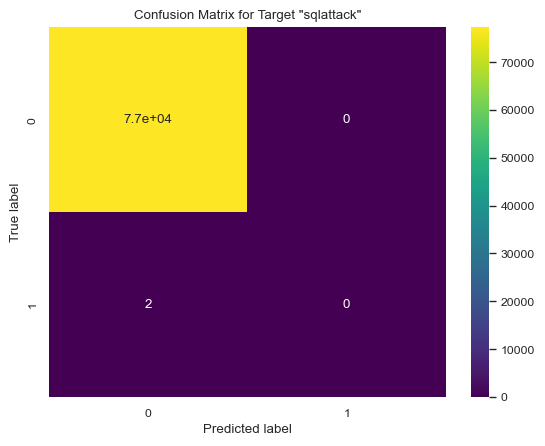

accuracy   : 0.999974
fbeta_score: 0.000000



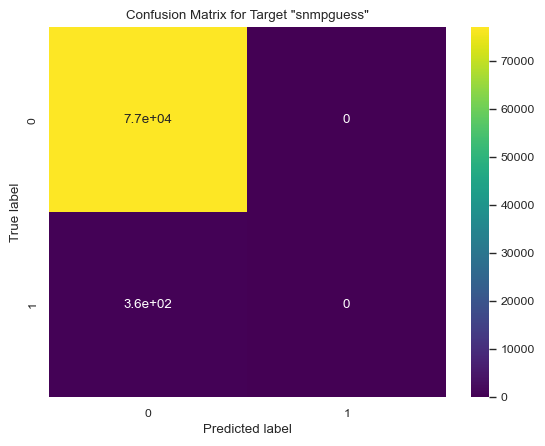

accuracy   : 0.995355
fbeta_score: 0.000000



In [171]:
for target, prediction in focused_rf_predictions.items():
    simple_confusion_matrix(focused_rf_true[target], prediction, target)
    print(f'accuracy   : {focused_rf_scores[target]["accuracy"]:.6f}')
    print(f'fbeta_score: {focused_rf_scores[target]["fbeta_score"]:.6f}\n')